In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import re
import itertools
import h5py
from ipywidgets import interact, IntSlider
from IPython.display import clear_output


SEED = 42 # Use same seed for replicable data generation
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Import data loader and loss function
from FNO2D_utils import (
    data_loader,
    relative_min_max,
    normal_RMSE,
)
# Set path to data set
path_xy = '/mimer/NOBACKUP/groups/ml_flame_storage/Max_1D/Data/2D/2D5000BC_x_y.h5'
path_TP = '/mimer/NOBACKUP/groups/ml_flame_storage/Max_1D/Data/2D/2D5000T_P.h5'
path_uv = '/mimer/NOBACKUP/groups/ml_flame_storage/Max_1D/Data/2D/2D5000u_v.h5'
from FNO2D import FNO2d

train_loader, test_loader, inp_max, inp_min, out_max, out_min, x_max, x_min, y_max, y_min = data_loader(path_xy, path_TP, path_uv, batch_size=100)

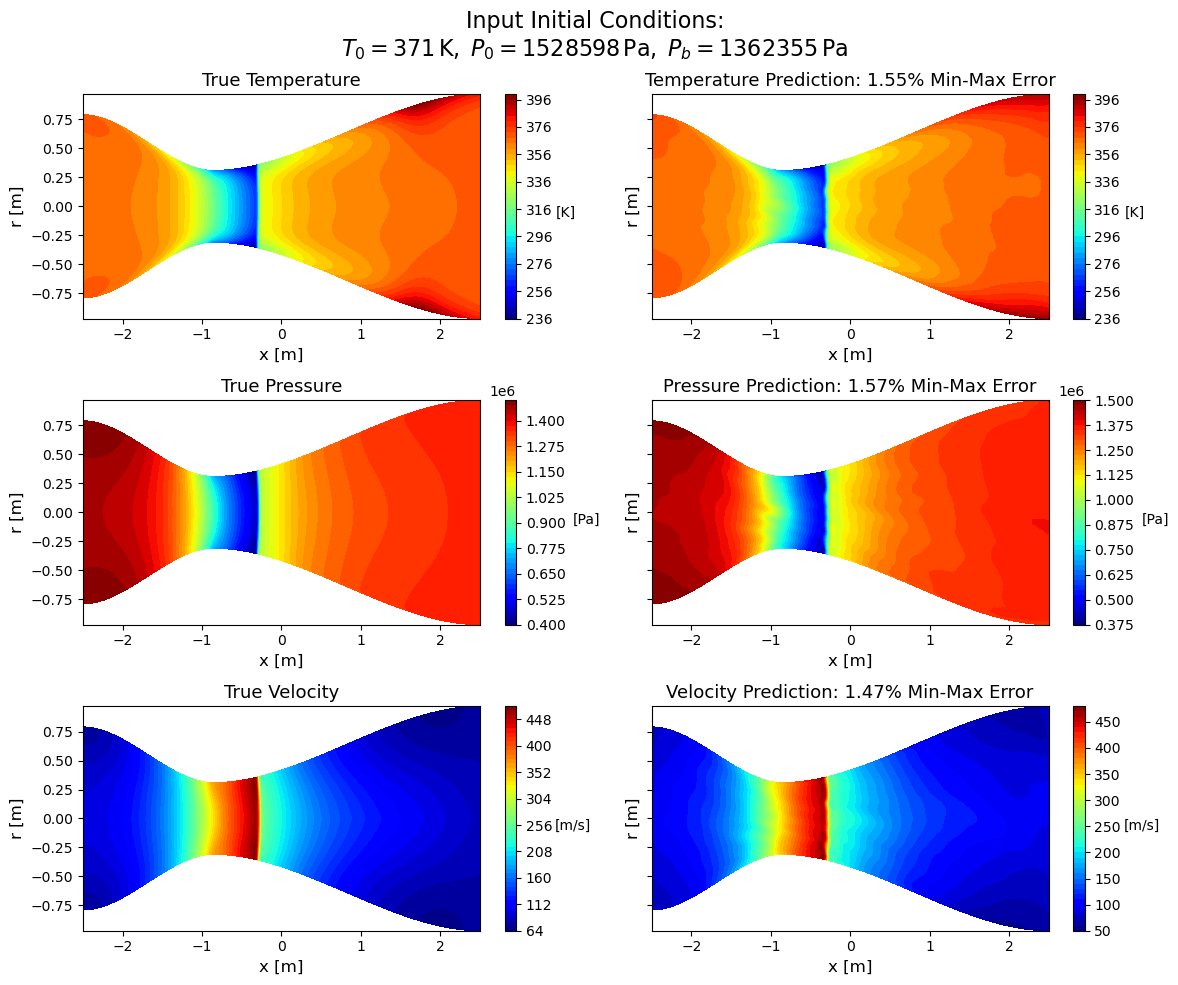

In [7]:

# ------------------------------------------------
# 5) Visualization
# ------------------------------------------------

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO2d(modes1=16, modes2 = 16, width=32, hidden_mlp=128, N_x=200, N_y = 50, N_fourier_layers=4).to(device)
model.load_state_dict(torch.load('2DModel.pth'))

# ------------------------------------------------
# Pick one batch and sample to visualize
# ------------------------------------------------
batch_index = 7 
sample_idx = 50 
with torch.no_grad():
    batch = next(itertools.islice(test_loader, batch_index, None))
    bc, target_field, x, y = batch
    bc = bc.to(device)
    target_field = target_field.to(device)
    x_batch = x.to(device)
    y_batch = y.to(device)
    pred_field = model(bc, x_batch, y_batch)

# ------------------------------------------------
# Rescale back from normalization if wanted
# ------------------------------------------------

pred_field   = (pred_field.cpu().numpy()   )*(out_max - out_min) + out_min
target_field = (target_field.cpu().numpy() )*(out_max - out_min) + out_min

bc_sample_norm = bc[sample_idx, :].cpu().numpy() 
bc_sample = (bc[sample_idx, :].cpu().numpy())*(inp_max-inp_min) + inp_min

x_vals = (x_batch.cpu().numpy() )*(x_max - x_min) + x_min
y_vals = (y_batch.cpu().numpy() )*(y_max - y_min) + y_min

pred = torch.from_numpy(pred_field[sample_idx,:,:]).unsqueeze(0)
target = torch.from_numpy(target_field[sample_idx,:,:]).unsqueeze(0)

sample_rel_min_max = relative_min_max(pred,target)*100

# Slice out the three fields for ground truth and prediction
T_true = target_field[sample_idx, :, :, 0]
P_true = target_field[sample_idx, :, :, 1]
U_true = target_field[sample_idx, :, :, 2]

T_pred = pred_field[sample_idx, :, :, 0]
P_pred = pred_field[sample_idx, :, :, 1]
U_pred = pred_field[sample_idx, :, :, 2]

X2d = x_vals[sample_idx]
Y2d = y_vals[sample_idx]

# create 3×2 subplot grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharex=False, sharey=True)

plt.suptitle(
    f"Input Initial Conditions:\n"
    rf"$T_0 = {bc_sample[0]:.0f}\,\mathrm{{K}},\; "
    rf"P_0 = {bc_sample[1]:.0f}\,\mathrm{{Pa}},\; "
    rf"P_b = {bc_sample[2]:.0f}\,\mathrm{{Pa}}$",
    fontsize=16
)

# Row 1: Temperature
cf = axes[0, 0].contourf(X2d, Y2d, T_true, levels=50, cmap='jet')
axes[0, 0].set_title("True Temperature", fontsize=13)
#plt.colorbar(cf, ax=axes[0, 0], label='[K]')
cbar1 = plt.colorbar(cf, ax=axes[0, 0]).set_label('[K]', rotation=0, labelpad=10)


cf = axes[0, 1].contourf(X2d, Y2d, T_pred, levels=50, cmap='jet')
axes[0, 1].set_title(f"Temperature Prediction: {sample_rel_min_max[0]:.2f}% Min-Max Error", fontsize=13)
cbar2 = plt.colorbar(cf, ax=axes[0, 1]).set_label('[K]', rotation=0, labelpad=10)

# Row 2: Pressure
cf = axes[1, 0].contourf(X2d, Y2d, P_true, levels=50, cmap='jet')
axes[1, 0].set_title("True Pressure", fontsize=13)
cbar3 = plt.colorbar(cf, ax=axes[1, 0]).set_label('[Pa]', rotation=0, labelpad=15)

cf = axes[1, 1].contourf(X2d, Y2d, P_pred, levels=50, cmap='jet')
axes[1, 1].set_title(f"Pressure Prediction: {sample_rel_min_max[1]:.2f}% Min-Max Error", fontsize=13)
cbar4 = plt.colorbar(cf, ax=axes[1, 1]).set_label('[Pa]', rotation=0, labelpad=15)

# Row 3: Velocity 
cf = axes[2, 0].contourf(X2d, Y2d, U_true, levels=50, cmap='jet')
axes[2, 0].set_title("True Velocity", fontsize=13)
cbar5 = plt.colorbar(cf, ax=axes[2, 0]).set_label('[m/s]', rotation=0, labelpad=15)

cf = axes[2, 1].contourf(X2d, Y2d, U_pred, levels=50, cmap='jet')
axes[2, 1].set_title(f"Velocity Prediction: {sample_rel_min_max[2]:.2f}% Min-Max Error", fontsize=13)
cbar6 = plt.colorbar(cf, ax=axes[2, 1]).set_label('[m/s]', rotation=0, labelpad=15)

for ax in axes.flatten():
    ax.set_xlabel('x [m]', fontsize=12)
    ax.set_ylabel('r [m]', fontsize=12)
plt.tight_layout()
plt.show()


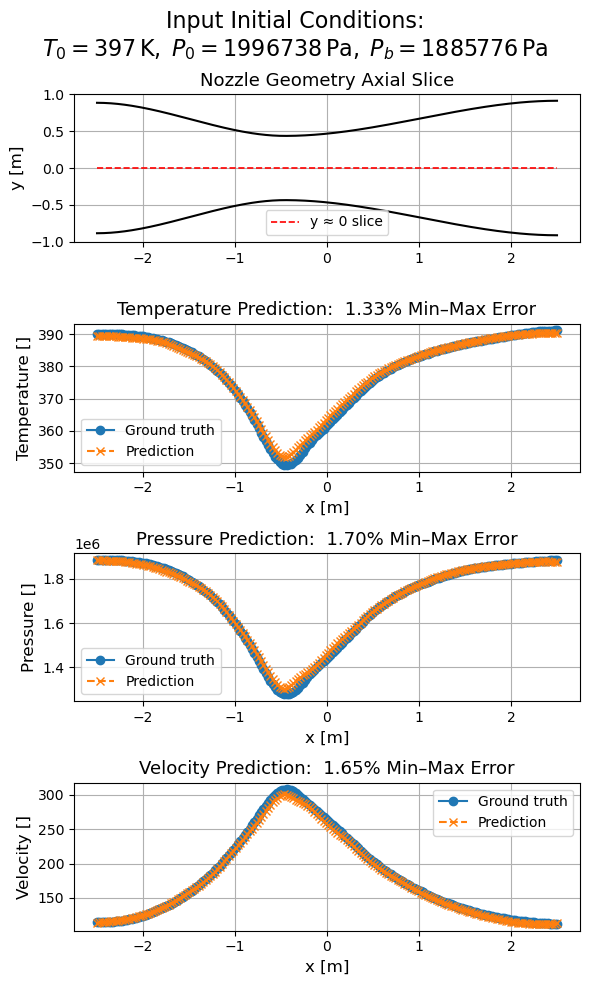

In [9]:

# ------------------------------------------------
# 1) Horizontal Line plot
# ------------------------------------------------

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO2d(modes1=16, modes2 = 16, width=32, hidden_mlp=128, N_x=200, N_y = 50, N_fourier_layers=4).to(device)
model.load_state_dict(torch.load('2DModel.pth'))
model.eval()

# ------------------------------------------------
# Pick one batch and sample to visualize
# ------------------------------------------------
batch_index = 5
sample_idx  = 26

with torch.no_grad():
    batch_iter = itertools.islice(test_loader, batch_index, None)
    bc, target_field, x, y = next(batch_iter)

    bc      = bc.to(device)
    target  = target_field.to(device)
    x_b     = x.to(device)
    y_b     = y.to(device)

    pred    = model(bc, x_b, y_b)

# ------------------------------------------------
# Rescale back from normalization if wanted
# ------------------------------------------------
pred_field   = pred.cpu().numpy()   * (out_max - out_min) + out_min  
target_field = target.cpu().numpy() * (out_max - out_min) + out_min
#pred_field   = pred.cpu().numpy()
#target_field = target.cpu().numpy()

bc_sample    = (bc[sample_idx].cpu().numpy()) * (inp_max - inp_min) + inp_min

x_vals = x_b.cpu().numpy() * (x_max - x_min) + x_min               
y_vals = y_b.cpu().numpy() * (y_max - y_min) + y_min

# ------------------------------------------------
# 4) Slice the fields at y ≈ 0
# ------------------------------------------------
T_true = target_field[sample_idx, ..., 0]
P_true = target_field[sample_idx, ..., 1]
U_true = target_field[sample_idx, ..., 2]

T_pred = pred_field[sample_idx, ..., 0]
P_pred = pred_field[sample_idx, ..., 1]
U_pred = pred_field[sample_idx, ..., 2]

X2d    = x_vals[sample_idx]     # (Nx, Ny)
Y2d    = y_vals[sample_idx]     # (Nx, Ny)

# column index where y is closest to zero
j0      = np.argmin(np.abs(Y2d[0, :] - 0.5))
x_line  = X2d[:, j0]

T_true_line, T_pred_line = T_true[:, j0], T_pred[:, j0]
P_true_line, P_pred_line = P_true[:, j0], P_pred[:, j0]
U_true_line, U_pred_line = U_true[:, j0], U_pred[:, j0]

# ------------------------------------------------
# 5) 1-D-style visualisation
# ------------------------------------------------
# Compute errors on the whole sample 
pred_torch   = torch.from_numpy(pred_field[sample_idx])[None, ...]    
target_torch = torch.from_numpy(target_field[sample_idx])[None, ...]  

rel_mm  = relative_min_max(pred_torch, target_torch) * 100   

# Figure + headline ------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(6, 10))
plt.suptitle(
    f"Input Initial Conditions:\n"
    rf"$T_0 = {bc_sample[0]:.0f}\,\mathrm{{K}},\;"
    rf"P_0 = {bc_sample[1]:.0f}\,\mathrm{{Pa}},\;"
    rf"P_b = {bc_sample[2]:.0f}\,\mathrm{{Pa}}$",
    fontsize=16, y=0.98
)

# geometry panel -----------------------------------------------------
axes[0].plot(X2d[:, 0],   Y2d[:, 0],  color='black')      
axes[0].plot(X2d[:, -1],  Y2d[:, -1], color='black')      
axes[0].plot(x_line, np.zeros_like(x_line),
             color='red', linestyle='--', linewidth=1.2,
             label='y ≈ 0 slice')
axes[0].set_ylabel('y [m]', fontsize=12)
axes[0].set_title('Nozzle Geometry Axial Slice', fontsize=13)
axes[0].legend()
axes[0].grid(True)

# line-cut profiles ------------------------------------------------
profiles_true = [T_true_line, P_true_line, U_true_line]
profiles_pred = [T_pred_line, P_pred_line, U_pred_line]
axis_labels   = ['Temperature []', 'Pressure []', 'Velocity []']
titles_base   = ['Temperature Prediction',
                 'Pressure Prediction',
                 'Velocity Prediction']

titles = [f"{t}: {e:5.2f}% Min–Max Error"
          for t, e in zip(titles_base, rel_mm)]

for i, ax in enumerate(axes[1:]):
    ax.plot(x_line, profiles_true[i],
            marker='o', linestyle='-',  label='Ground truth')
    ax.plot(x_line, profiles_pred[i],
            marker='x', linestyle='--', label='Prediction')
    ax.set_title(titles[i], fontsize=13)
    ax.set_xlabel('x [m]', fontsize=12)
    ax.set_ylabel(axis_labels[i], fontsize=12)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [11]:
"""
--------------------------------------------------------------------------
FNO-2D   •   Inference + y≈0 (horizontal) *and*  x≈x₀  (vertical) slices
--------------------------------------------------------------------------
"""


# ------------------------------------------------
# 1) Model loading  (same as before)
# ------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO2d(modes1=16, modes2=16, width=32, hidden_mlp=128,
              N_x=200, N_y=50, N_fourier_layers=4).to(device)
model.load_state_dict(torch.load('2DModel.pth',
                                 map_location=device))
model.eval()

# ------------------------------------------------
# 2) Grab one batch & run inference  (same as before)
# ------------------------------------------------
batch_index, sample_idx = 5, 26
with torch.no_grad():
    bc, target_field, x, y = next(itertools.islice(test_loader,
                                                   batch_index, None))
    bc, target_field, x_b, y_b = (t.to(device)
                                  for t in (bc, target_field, x, y))
    pred = model(bc, x_b, y_b)

# ------------------------------------------------
# 3) De-normalise to physical units  (same as before)
# ------------------------------------------------

#pred_field   = pred.cpu().numpy()   * (out_max - out_min) + out_min
#target_field = target_field.cpu().numpy() * (out_max - out_min) + out_min
pred_field = pred.cpu().numpy()
target_field = target_field.cpu().numpy()
bc_sample    = (bc[sample_idx].cpu().numpy()) * (inp_max - inp_min) + inp_min
x_vals = x_b.cpu().numpy() * (x_max - x_min) + x_min
y_vals = y_b.cpu().numpy() * (y_max - y_min) + y_min

# ------------------------------------------------
# 4) Convenience handles for this sample  (same as before)
# ------------------------------------------------
print(target_field.shape)
T_true = target_field[sample_idx, :, :, 0]
P_true = target_field[sample_idx, :, :, 1]
U_true = target_field[sample_idx, :, :, 2]
T_pred = pred_field[sample_idx,:,:,0]
P_pred = pred_field[sample_idx,:,:,1]
U_pred = pred_field[sample_idx,:,:,2]

X2d,   Y2d             = x_vals[sample_idx],      y_vals[sample_idx]

# ════════════════════════════════════════════════════════════════════════
# 6)  vertical slice  x ≈ x₀ (e.g. the centre-line or throat)
# ════════════════════════════════════════════════════════════════════════
# ---- choose the target x-coordinate -----------------------------------
x_target = 0.5                               # <-- change to taste
i0       = np.argmin(np.abs(X2d[:, 0] - x_target))   # row index

y_line   = Y2d[i0]          # shape (Ny,)

T_true_v, T_pred_v = T_true[i0], T_pred[i0]
P_true_v, P_pred_v = P_true[i0], P_pred[i0]
U_true_v, U_pred_v = U_true[i0], U_pred[i0]

true_plot = torch.from_numpy(target_field[sample_idx, i0])\
                 .unsqueeze(0)          # shape → (1, Ny, 3)

pred_plot = torch.from_numpy(pred_field[sample_idx, i0])\
                 .unsqueeze(0)


# ---- compute global sample errors (same trick as before) ---------------
pred_t  = torch.from_numpy(pred_field  [sample_idx])[None]

targ_t  = torch.from_numpy(target_field[sample_idx])[None]

rel_mm  = relative_min_max1D(true_plot, pred_plot)*100      # (3,)

rel_mm = rel_mm.numpy()
print("Field errors  [T, P, U]  (L2 %) :",
      (relative_l2(pred_t, targ_t)*100).numpy())

# ---- figure ------------------------------------------------------------
fig, axes = plt.subplots(4, 1, figsize=(6, 10))
plt.suptitle(
    f"Input / BC values:\n"
    rf"$T_0 = {bc_sample[0]:.0f}\,\mathrm{{K}},\;"
    rf"P_0 = {bc_sample[1]:.0f}\,\mathrm{{Pa}},\;"
    rf"P_b = {bc_sample[2]:.0f}\,\mathrm{{Pa}}$",
    fontsize=16, y=0.98
)

# (a) geometry panel – show the x≈x₀ cut
axes[0].plot(X2d[:, 0],   Y2d[:, 0],   color='black')     # lower wall
axes[0].plot(X2d[:, -1],  Y2d[:, -1],  color='black')     # upper wall
axes[0].plot(np.full_like(y_line, X2d[i0, 0]),
             y_line, color='red', linestyle='--',
             linewidth=1.2, label=f'x ≈ {X2d[i0,0]:.3f} m slice')
axes[0].set_xlabel('x [m]', fontsize=12)
axes[0].set_ylabel('y [m]', fontsize=12)
axes[0].set_title('Nozzle Geometry Radial Slice', fontsize=13)
axes[0].legend(); axes[0].grid(True)

# (b-d) variable profiles vs y
profiles_t = [T_true_v, P_true_v, U_true_v]
profiles_p = [T_pred_v, P_pred_v, U_pred_v]
axis_lbl   = ['Temperature []', 'Pressure []', 'Velocity []']
titles_b   = ['Temperature prediction',
              'Pressure prediction',
              'Velocity prediction']
titles_v   = [f"{t}: {e:5.2f}% Min–Max error"
              for t, e in zip(titles_b, rel_mm)]

for k, ax in enumerate(axes[1:]):
    ax.plot(y_line, profiles_t[k], marker='o', linestyle='-',
            label='Ground truth')
    ax.plot(y_line, profiles_p[k], marker='x', linestyle='--',
            label='Prediction')
    ax.set_title(titles_v[k], fontsize=13)
    ax.set_xlabel('y [m]', fontsize=12)
    ax.set_ylabel(axis_lbl[k], fontsize=12)
    ax.grid(True); ax.legend()

plt.tight_layout()
#plt.savefig('/mimer/NOBACKUP/groups/ml_flame_storage/Max_1D/Images/VerticalLinePlot_Subsonic.png', dpi=300, bbox_inches='tight')
plt.show()


(100, 200, 50, 3)


NameError: name 'relative_min_max1D' is not defined

In [15]:
# ------------------------------------------------
# Contour plot slider for samples and batches
# ------------------------------------------------

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FNO2d(modes1=16, modes2 = 16, width=32, hidden_mlp=128, N_x=200, N_y = 50, N_fourier_layers=4).to(device)
model.load_state_dict(torch.load('2DModel.pth'))
model.eval()

num_batches = len(test_loader)

# Grab a dummy batch to get batch size
first_batch = next(iter(test_loader))     
batch_size   = first_batch[0].shape[0]

# Define outputs
field_names = ['Temperature', 'Pressure', 'Velocity']
units       = ['K', 'Pa', 'm/s']


def view(batch_idx: int = 0, sample_idx: int = 0):
    clear_output(wait=True)                

    # Load the batch
    batch = next(itertools.islice(test_loader, batch_idx, None))
    bc, target_field, x, y = batch
    bc, target_field = bc.to(device), target_field.to(device)
    x_batch, y_batch = x.to(device), y.to(device)

    # Normalized data
    with torch.no_grad():
        pred_field = model(bc, x_batch, y_batch)

    # Denormalize
    pred_field   = (pred_field.cpu().numpy())   * (out_max - out_min) + out_min
    target_field = (target_field.cpu().numpy()) * (out_max - out_min) + out_min
    bc_phys      = (bc[sample_idx].cpu().numpy()) * (inp_max - inp_min) + inp_min

    X2d = (x_batch.cpu().numpy()) * (x_max - x_min) + x_min   
    Y2d = (y_batch.cpu().numpy()) * (y_max - y_min) + y_min

    # Relative min-max for each channel
    p = torch.from_numpy(pred_field  [sample_idx]).unsqueeze(0)
    t = torch.from_numpy(target_field[sample_idx]).unsqueeze(0)
    rel_err = (relative_min_max(p, t) * 100).flatten()        # (3,)

    # Slice fields
    true_fields = [target_field[sample_idx, :, :, ch] for ch in range(3)]
    pred_fields = [pred_field  [sample_idx, :, :, ch] for ch in range(3)]

    # Plotting
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), sharey=True)
    plt.suptitle(
        ("Input Initial Conditions:\n"
         rf"$T_0 = {bc_phys[0]:.0f}\,\mathrm{{K}},\; "
         rf"P_0 = {bc_phys[1]:.0f}\,\mathrm{{Pa}},\; "
         rf"P_b = {bc_phys[2]:.0f}\,\mathrm{{Pa}}$"),
        fontsize=16
    )

    for row in range(3):
        cf = axes[row, 0].contourf(X2d[sample_idx], Y2d[sample_idx],
                                   true_fields[row], levels=50, cmap='jet')
        axes[row, 0].set_title(f"True {field_names[row]}", fontsize=13)
        plt.colorbar(cf, ax=axes[row, 0]).set_label(f"[{units[row]}]",
                                                    rotation=0, labelpad=10)
        
        cf = axes[row, 1].contourf(X2d[sample_idx], Y2d[sample_idx],
                                   pred_fields[row], levels=50, cmap='jet')
        axes[row, 1].set_title(
            f"{field_names[row]} Prediction: {rel_err[row]:.2f}% Rel Min-Max",
            fontsize=13
        )
        plt.colorbar(cf, ax=axes[row, 1]).set_label(f"[{units[row]}]",
                                                    rotation=0, labelpad=10)
    for ax in axes.flatten():
        ax.set_xlabel('x [m]', fontsize=12)
        ax.set_ylabel('r [m]', fontsize=12)

    plt.tight_layout()
    plt.show()

# Two linked sliders
interact(
    view,
    batch_idx  = IntSlider(0, 0, num_batches-1, 1, description='Batch'),
    sample_idx = IntSlider(0, 0, batch_size-1, 1, description='Sample')
);


interactive(children=(IntSlider(value=0, description='Batch', max=9), IntSlider(value=0, description='Sample',…